# Part 1. Segmentation — 10 points

### Task

Train a neural network to segment cells edges.

In this task, you won't be provided with any code snippets, just input data and target metric — intersection-over-union (IoU) (see the implementation below).

You should train your neural network to predict a mask of edge pixels (pixels in gt images with value greater than 0).

Use everything you have learnt by now: 
* any architectures for semantic segmentation (encoder-decoder like or based on dilated convolutions), we recommend using UNet: https://towardsdatascience.com/unet-line-by-line-explanation-9b191c76baf5)
* data augmentation (you will need that since train set consists of just 41 images)
* fine-tuning

You are not allowed to do only one thing: to train you network on a test set.

The final solution will consist of an ipython notebook with code (for final network training + any experiments with data) and an archive with png images with network predictions for test images (one-channel images, 0 - for non-edge pixels, any non-zero value for edge pixels).

A good network should be able to segment images with iou >= 0.29. This is not a strict criterion of full points solution, but try to obtain similar or better numbers.

Practical notes:
* There is a hard data class imbalance in dataset, so the network output will be biased toward "zero" class. You can either tune the minimal probability threshold for "edge" class, or add class weights to increase the cost of edge pixels in optimized loss.
* Dataset is small so actively use data augmentation: rotations, flip, random contrast and brightness
* Better spend time on experiments with neural network than on postprocessing tricks (i.e test set augmentation).
* Keep in mind that network architecture defines receptive field of pixel. If the size of network input is smaller than receptive field of output pixel, than probably you can throw some layers without loss of quality. It is ok to modify "of-the-shelf" architectures. 

Good luck!

In [1]:
### Download the dataset ###
# !wget https://www.dropbox.com/s/jy34yowcf85ydba/data.zip?dl=0 -O data.zip
# !unzip -q data.zip

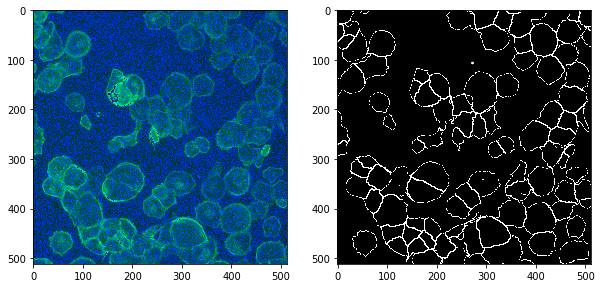

In [2]:
### Visualize the data ###
import matplotlib.pyplot as plt
import numpy as np
import skimage
from skimage import io
%matplotlib inline



# Human HT29 colon-cancer cells
plt.figure(figsize=(10,8))
plt.subplot(1,2,1)
im = skimage.img_as_ubyte(io.imread('BBBC018_v1_images-fixed/train/00735-actin.DIB.bmp'))
plt.imshow(im)
plt.subplot(1,2,2)
mask = skimage.img_as_ubyte(io.imread('BBBC018_v1_outlines/train/00735-cells.png'))
plt.imshow(mask, 'gray')

In [3]:
### Target metric ###
def calc_iou(prediction, ground_truth):
    n_images = len(prediction)
    intersection, union = 0, 0
    for i in range(n_images):
        intersection += np.logical_and(prediction[i] > 0, ground_truth[i] > 0).astype(np.float32).sum() 
        union += np.logical_or(prediction[i] > 0, ground_truth[i] > 0).astype(np.float32).sum()
    return float(intersection) / union

In [4]:
# YOUR CODE HERE
import torch
from torch import nn
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import datasets, transforms, utils
from IPython import display
import os
from tqdm import tqdm
import cv2

import albumentations as albu

In [5]:
class SegmDataset(Dataset):
    def __init__(self, images_folder, masks_folder, transform=None):
        self.transform = transform
        self.images_folder = images_folder
        self.masks_folder = masks_folder
        self.images = sorted(os.listdir(images_folder))
        self.masks = sorted(os.listdir(masks_folder))
        
        
    def __getitem__(self, index):
        image = cv2.imread(self.images_folder + '/' + self.images[index])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks_folder + '/' + self.masks[index], cv2.IMREAD_GRAYSCALE)
        pair = {'image': image, 'mask': mask}
        if self.transform:
            pair = self.transform(image=pair['image'], mask=pair['mask'])
        return transforms.ToTensor()(pair['image']), transforms.ToTensor()(pair['mask'])
    
    
    def __len__(self):
        return len(self.images)

For this task I used the model from segmentation seminar

In [18]:
class UnetDownBlock(nn.Module):
    def __init__(self, in_channels, out_channels, pooling=True):
        super().__init__()
        self.convs = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(out_channels),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(out_channels),
        )
        self.maxpool = nn.MaxPool2d(kernel_size=2)
        
        
    def forward(self, x):
        out_before_pooling = self.convs(x)
        out = self.maxpool(out_before_pooling)

        return out, out_before_pooling
    
    
class UnetUpBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.upsample = nn.Upsample(scale_factor=2)
        self.convs = nn.Sequential(
            nn.Conv2d(in_channels * 2, out_channels, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(out_channels),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(out_channels),
        )
        
        
    def forward(self, x, x_bridge):
        x_up = self.upsample(x)
        x_concat = torch.cat([x_up, x_bridge], dim=1)
        out = self.convs(x_concat)
        
        return out

    
class Unet(nn.Module):
    def __init__(self, n_base_channels=64, out_channels=1):
        super().__init__()
        self.down_blocks = nn.ModuleList([
            UnetDownBlock(3, n_base_channels),
            UnetDownBlock(n_base_channels, n_base_channels * 2),
            UnetDownBlock(n_base_channels * 2, n_base_channels * 4),
            UnetDownBlock(n_base_channels * 4, n_base_channels * 4),
            UnetDownBlock(n_base_channels * 4, n_base_channels * 4)
        ])
        self.up_blocks = nn.ModuleList([
            UnetUpBlock(n_base_channels * 4, n_base_channels * 4),
            UnetUpBlock(n_base_channels * 4, n_base_channels * 2),
            UnetUpBlock(n_base_channels * 2, n_base_channels),
            UnetUpBlock(n_base_channels, n_base_channels),
        ])
        self.final_block = nn.Sequential(
            nn.Conv2d(n_base_channels, out_channels, kernel_size=3, padding=1),
        )
            
        
    def forward(self, x):
        out = x
        outputs_before_pooling = []
        for i, block in enumerate(self.down_blocks):
            out, before_pooling = block(out)
            outputs_before_pooling.append(before_pooling)
        out = before_pooling
        
        for i, block in enumerate(self.up_blocks):
            out = block(out, outputs_before_pooling[-i - 2])
        out = self.final_block(out)
        
        return out

In [7]:
trans = albu.Compose([albu.OneOf([albu.Transpose(p=0.9), albu.HorizontalFlip(p=0.9), 
                                  albu.VerticalFlip(p=0.9), albu.RandomRotate90(p=0.9)]),
                      albu.ShiftScaleRotate(p=0.8),
                      albu.ElasticTransform(p=0.8, alpha=200, sigma=0.05),
                      albu.RandomBrightnessContrast(p=0.7),
                      albu.RandomGamma(p=0.7),
                      albu.RandomSizedCrop(p=1, min_max_height=(300, 400), height=512, width=512, interpolation=cv2.INTER_LINEAR)])

train_dataset = SegmDataset('./BBBC018_v1_images-fixed/train/', 'BBBC018_v1_outlines/train/', trans)
val_dataset = SegmDataset('./BBBC018_v1_images-fixed/val/', 'BBBC018_v1_outlines/val/', None)

train_dataloader = DataLoader(train_dataset, batch_size=2, num_workers=5, shuffle=True, drop_last=True)
val_dataloader = DataLoader(val_dataset, batch_size=1, num_workers=5, shuffle=False)
len(train_dataloader)

20

In [8]:
def get_best_iou(model, loader):
    threshold_search = np.linspace(0, 1, 200)
    best_iou = 0
    true_masks = np.array([elem[1].cpu().detach().numpy() for elem in loader])
    for threshold in tqdm(threshold_search):
        predicted_masks = np.zeros((7, 1, 512, 512))
        for i, (image, mask) in enumerate(loader):
            predicted_image = model(image.to(device))
            predicted_masks[i] = predicted_image.cpu().detach().numpy() > threshold
        iou = calc_iou(predicted_masks, true_masks)
        if iou > best_iou:
            best_iou = iou
            best_threshold = threshold
    return best_threshold, best_iou


def train(model, train_dataloader, val_dataloader, n_epochs=200):
    temp_dataset = SegmDataset('./BBBC018_v1_images-fixed/train/', 'BBBC018_v1_outlines/train/', None)
    balance = 0
    for i in range(len(temp_dataset)):
        balance += temp_dataset[i][1].mean().item() / len(temp_dataset)
    
    learning_rate = 5e-4
    opt = torch.optim.Adam(model.parameters(), lr=learning_rate)
#     criterion = torch.nn.BCELoss()
    criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(1 / balance))
    scheduler = StepLR(opt, step_size=25, gamma=0.5)
    best_iou, threshold = 0, 0.2
    loss_history, iou_history = [], [best_iou]

    for i in tqdm(range(n_epochs)):
        model.train()
        for j, (batch_img, batch_masks) in enumerate(train_dataloader):
            predicted_images = model(batch_img.to(device))
            batch_masks = batch_masks.to(device)
            loss = criterion(predicted_images, batch_masks)
            loss.backward()
            opt.step()
            opt.zero_grad()
            loss_history.append(loss.item())
        scheduler.step(loss)

        model.eval()
        for j, (batch_img, batch_masks) in enumerate(val_dataloader):
            predicted_images = model(batch_img.to(device))
            batch_masks = batch_masks.to(device)
            loss = criterion(predicted_images, batch_masks)

        if i % 15 == 0:
            threshold, iou = get_best_iou(model, val_dataloader)
            best_iou = iou if iou > best_iou else best_iou
            iou_history.append(best_iou)
            
            display.clear_output(True)
            plt.figure(figsize=(10, 8))
            plt.plot(loss_history)
            plt.grid()
            plt.title('Loss', fontsize=20)
            plt.show()
            
            plt.figure(figsize=(10, 8))
            plt.plot(iou_history)
            plt.grid()
            plt.title('IOU', fontsize=20)
            plt.show()
        
    return threshold, best_iou

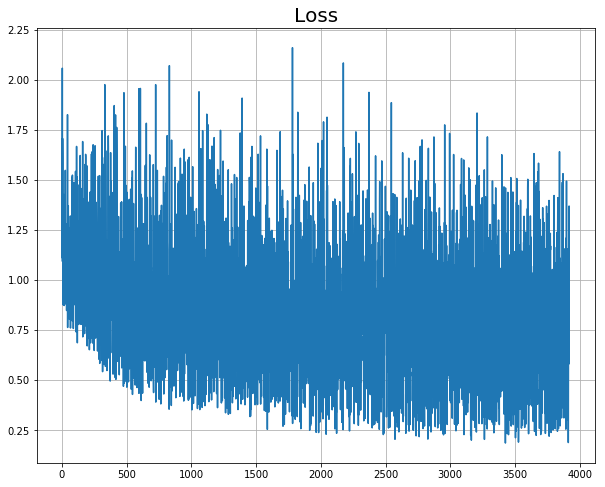

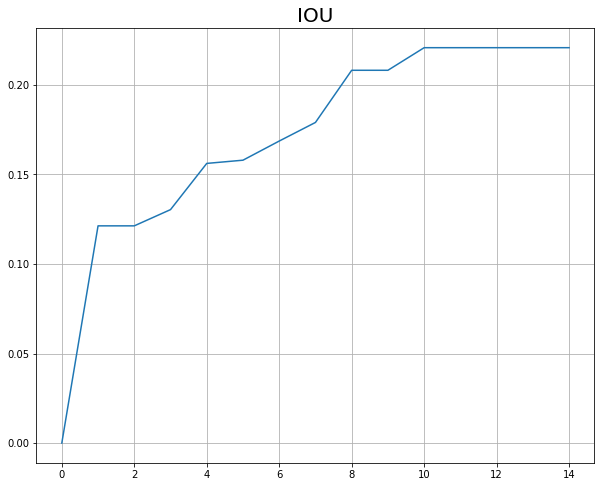

100%|██████████| 200/200 [42:25<00:00, 12.73s/it]


In [9]:
device = torch.device("cuda")
model = Unet().to(device)
threshold, iou = train(model, train_dataloader, val_dataloader)

In [10]:
print(f'Best validation IOU: {iou:.2f}')

Best validation IOU: 0.22


I've done a bunch of experiments with different learning rates, two different losses and many augmentations and finally came up to the parameters you can see above. I found out that batchnorms improved the score rather well and augmentations which distort image (optical and grid distortion) make it worse. Introducing classes balance to to loss made a picture slightly better, but I still retune threshold frequently.

# Part 2. Deep Image Prior (DIP) — 10 points


### Theory

Deep Image Prior [1] can be viewed as an implicit conditional generative model:

\begin{equation}
p(x \mid x_0) = \int p(x \mid \theta, \mathcal{z}, x_0)\, p(\theta \mid x_0)\, p(\mathcal{z})\,d\theta\,d\mathcal{z}\,,
\end{equation}

Latent parameters of this model consist of the weights of the neural network $\theta$ and a fixed input $\mathcal{z}$, which is fed into the network. 

If we denote the network by $f$, the output $x$ is produced in the following way:

$$
x = f_\theta(\mathcal{z}).
$$

This this model is implicit: we cannot evaluate the integral above. In the case of DIP, both likelihood and prior are unknown. But, as with all implicit models, we can perform sampling from $p(x \mid x_0)$.

Similarly to style transfer models, the sampling is done via optimization. The algorithm is following:

1. Sample a data point $x_0$ from a data distribution.
2. Initialize $\theta$ with $\theta_0$ and $\mathcal{z}$ with $z$.
3. Perform an optimization of some error function $E$ with respect to the weights of the neural network: 

$$
\min_\theta E(f_\theta(z), x_0).
$$

4. Hand-pick the weights $\theta_M$ at intermediate optimization step $M$ and denote them as $\theta^*$

Now, the most counter-intuitive thing about this model is the fact that it can be used for image restoration (inpainting, denoising) and super-resolution. In this case, $x_0$ is a degraded version of a target image $x$. And, by trying to predict this degraded image using a network (via minimization of an error between the predicted image $f_\theta(z)$ and $x_0$) at some optimization step $M$ we will obtain its restored or upscaled version.

The main trick is that instead of optimizing with respect to an input tensor $z$, like in style-transfer models, we keep the input fixed and optimize with repect to the weights of the network. Brief explanation of this result is provided below, for more details please refer to [1].

On one hand, a convolutional neural network is close to a universal functional approximator, and, given enough training iterations, it can fit a manifold of arbitrary complexity [2]. On the other hand, it is observed in practice that early stopping leads to solutions with good generalization (same networks, as in [2], can be properly trained to achieve good generalization). In DIP paper this phenomena is explored for image synthesis, and it was shown that the same intuition about generalization also applies here. Remarkably though, the generalization results were obtained for a highly complex manifold of natural images, which once again shows how well-suited are convolutional neural networks for image processing and synthesis.

### Task

The general goal of the task is for you to reproduce the results from the paper:

using a Mean Square Error (MSE) as an error function,

1. perform denoising of the images in the folder "data/denoising",
2. perform inpaiting of the images in the folder "data/inpaiting" (for inpainting, apply the loss only over the known area of the image using a provided mask),

with a UNet-style network (with 4 downsampling layers, and 16, 32, 64 and 128 filters at the end of each block).

For architecture reference, please read this blog post:
https://towardsdatascience.com/unet-line-by-line-explanation-9b191c76baf5.

If you have used a UNet-style network in the first part of the assignment on segmentation, you can reuse the code.

### Notes

- You have to play with the number of iterations $M$ used for early stopping, and use the optimal value to denoise and inpaint the images from the task. For each task you may need to find different optimal values. The source code and the results of your experiments should be provided in this notebook.
- Use Adam as your default optimizer, but feel free to experiment with the other optimizers or even architectures of the network. The most thorough experiments will be graded with bonus points. The final score for the homework is calculated as $\min ( \text{points} + \text{bonus_points}, \text{max_points} ) $.

### References

[1] Ulyanov et. al., "Deep Image Prior", CVPR 2018, https://arxiv.org/abs/1711.10925

[2] Zhang et. al., "Understanding deep learning requires rethinking generalization", ICLR 2017, https://arxiv.org/abs/1611.03530

In [11]:
### Download the dataset ###
# !wget https://www.dropbox.com/s/si5o4dp4qa59cyy/data.zip?dl=0 -O data.zip
# !unzip -q data.zip

In [1]:
# YOUR CODE HERE
# YOUR CODE HERE
import torch
from torch import nn
import torchvision
from torchvision import datasets, transforms, utils
from IPython import display
import os
from tqdm import tqdm
import cv2
import matplotlib.pyplot as plt

In [2]:
class UnetDownBlock(nn.Module):
    def __init__(self, in_channels, out_channels, pooling=True):
        super().__init__()
        self.convs = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(out_channels),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(out_channels),
        )
        self.maxpool = nn.MaxPool2d(kernel_size=2)
        
        
    def forward(self, x):
        out_before_pooling = self.convs(x)
        out = self.maxpool(out_before_pooling)

        return out, out_before_pooling
    
    
class UnetUpBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.upsample = nn.Upsample(scale_factor=2)
        self.convs = nn.Sequential(
            nn.Conv2d(in_channels * 2, out_channels, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(out_channels),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(out_channels),
        )
        
        
    def forward(self, x, x_bridge):
        x_up = self.upsample(x)
        x_concat = torch.cat([x_up, x_bridge], dim=1)
        out = self.convs(x_concat)
        
        return out

    
class Unet(nn.Module):
    def __init__(self, n_base_channels=64, out_channels=3):
        super().__init__()
        self.down_blocks = nn.ModuleList([
            UnetDownBlock(3, n_base_channels),
            UnetDownBlock(n_base_channels, n_base_channels * 2),
            UnetDownBlock(n_base_channels * 2, n_base_channels * 4),
            UnetDownBlock(n_base_channels * 4, n_base_channels * 8),
            UnetDownBlock(n_base_channels * 8, n_base_channels * 8)
        ])
        self.up_blocks = nn.ModuleList([
            UnetUpBlock(n_base_channels * 8, n_base_channels * 4),
            UnetUpBlock(n_base_channels * 4, n_base_channels * 2),
            UnetUpBlock(n_base_channels * 2, n_base_channels),
            UnetUpBlock(n_base_channels, n_base_channels),
        ])
        self.final_block = nn.Sequential(
            nn.Conv2d(n_base_channels, out_channels, kernel_size=3, padding=1),
            nn.Sigmoid()
        )
            
        
    def forward(self, x):
        out = x
        outputs_before_pooling = []
        for i, block in enumerate(self.down_blocks):
            out, before_pooling = block(out)
            outputs_before_pooling.append(before_pooling)
        out = before_pooling
        
        for i, block in enumerate(self.up_blocks):
            out = block(out, outputs_before_pooling[-i - 2])
        out = self.final_block(out)
        
        return out

In [3]:
def train(model, img, n_epochs=1500, spoil=True):
    opt = torch.optim.Adam(model.parameters())
    criterion = torch.nn.MSELoss()
    img = transforms.Compose([transforms.ToPILImage(),
                              transforms.Resize((img.shape[0] - img.shape[0] % 16, 
                                                 img.shape[1] - img.shape[1] % 16)),
                              transforms.ToTensor()])(img)
    size = img.size()
    img.resize_(1, *size)
    if spoil:
        img = torch.clamp(img + torch.randn(1, *size) * 0.1, 0, 1)
    img = img.to(device).type(torch.cuda.FloatTensor)
    z = torch.randn(1, *size) * 0.1  # noise var 0.1

    for i in tqdm(range(n_epochs)):
        z = (z.cpu() + torch.randn(1, *size) / 30).to(device)  # perturbations var 1 / 30
        predicted_img = model(z)
        loss = criterion(predicted_img, img)
        loss.backward()
        opt.step()
        opt.zero_grad()

        if i % 15 == 0:
            display.clear_output(True)
            fig, axs = plt.subplots(1, 2, figsize=(14, 7))
            axs[0].imshow(transforms.ToPILImage()(img.cpu().squeeze()))
            axs[0].set_title('Original')
            axs[1].imshow(transforms.ToPILImage()(predicted_img.detach().cpu().squeeze()))
            axs[1].set_title('Denoised')
            plt.show()

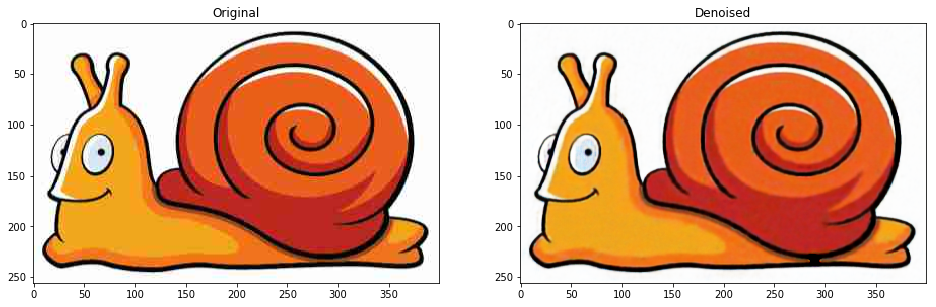


100%|██████████| 1500/1500 [01:17<00:00, 19.29it/s]


In [7]:
img = cv2.imread('./data/denoising/snail.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
device = torch.device("cuda")
model = Unet(n_base_channels=16, out_channels=3)
model.to(device)
train(model, img, spoil=False)

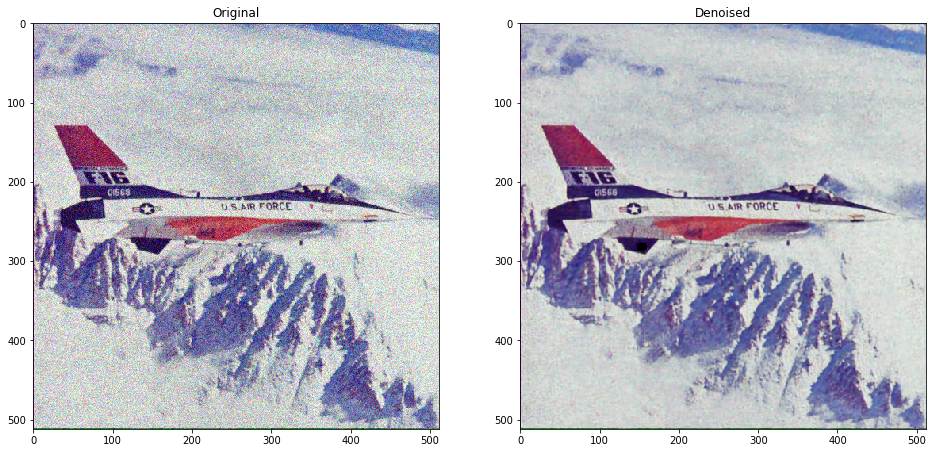


100%|██████████| 1500/1500 [01:58<00:00, 12.69it/s]


In [9]:
img = cv2.imread('./data/denoising/F16_GT.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
device = torch.device("cuda")
model = Unet(n_base_channels=16, out_channels=3)
model.to(device)
train(model, img, spoil=True)

In [3]:
class Unet(nn.Module):
    def __init__(self, n_base_channels=64, out_channels=3):
        super().__init__()
        self.down_blocks = nn.ModuleList([
            UnetDownBlock(3, n_base_channels),
            UnetDownBlock(n_base_channels, n_base_channels),
            UnetDownBlock(n_base_channels, n_base_channels),
            UnetDownBlock(n_base_channels, n_base_channels),
            UnetDownBlock(n_base_channels, n_base_channels)
        ])
        self.up_blocks = nn.ModuleList([
            UnetUpBlock(n_base_channels, n_base_channels),
            UnetUpBlock(n_base_channels, n_base_channels),
            UnetUpBlock(n_base_channels, n_base_channels),
            UnetUpBlock(n_base_channels, n_base_channels),
        ])
        self.final_block = nn.Sequential(
            nn.Conv2d(n_base_channels, out_channels, kernel_size=3, padding=1),
            nn.Sigmoid()
        )
            
        
    def forward(self, x):
        out = x
        outputs_before_pooling = []
        for i, block in enumerate(self.down_blocks):
            out, before_pooling = block(out)
            outputs_before_pooling.append(before_pooling)
        out = before_pooling
        
        for i, block in enumerate(self.up_blocks):
            out = block(out, outputs_before_pooling[-i - 2])
        out = self.final_block(out)
        
        return out


def train(model, img, mask, n_epochs=4000):
    opt = torch.optim.Adam(model.parameters())
    criterion = torch.nn.MSELoss()
    img = transforms.Compose([transforms.ToPILImage(),
                              transforms.Resize((img.shape[0] - img.shape[0] % 16, 
                                                 img.shape[1] - img.shape[1] % 16)),
                              transforms.ToTensor()])(img)
    mask = transforms.Compose([transforms.ToPILImage(),
                              transforms.Resize((mask.shape[0] - mask.shape[0] % 16, 
                                                 mask.shape[1] - mask.shape[1] % 16)),
                              transforms.ToTensor()])(mask)
    size = img.size()
    img.resize_(1, *size)
    mask.resize_(1, *size)
    img, mask = img.to(device).type(torch.cuda.FloatTensor), mask.to(device).type(torch.cuda.FloatTensor)
    z = torch.randn(1, *size) * 0.1  # noise var 0.1

    for i in tqdm(range(n_epochs)):
        z = (z.cpu() + torch.randn(1, *size) / 30).to(device)  # perturbations var 1 / 30
        predicted_img = model(z)
        loss = criterion(predicted_img * mask, img * mask)
        loss.backward()
        opt.step()
        opt.zero_grad()

        if i % 15 == 0:
            display.clear_output(True)
            fig, axs = plt.subplots(1, 2, figsize=(14, 7))
            axs[0].imshow(transforms.ToPILImage()((img * mask).cpu().squeeze()))
            axs[0].set_title('Image with mask')
            axs[1].imshow(transforms.ToPILImage()(predicted_img.detach().cpu().squeeze()))
            axs[1].set_title('Inpainted image')
            plt.show()

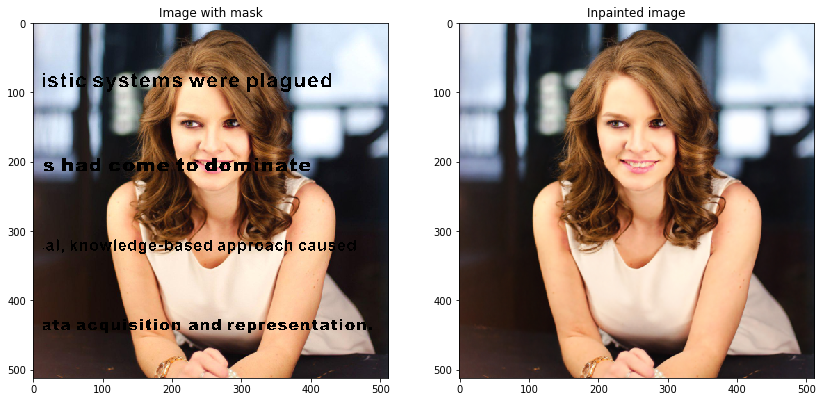



100%|█████████▉| 3991/4000 [18:45<00:04,  2.17it/s]

100%|█████████▉| 3993/4000 [18:45<00:02,  2.74it/s]

100%|█████████▉| 3994/4000 [18:45<00:02,  2.83it/s]

100%|█████████▉| 3995/4000 [18:45<00:01,  3.11it/s]

100%|█████████▉| 3996/4000 [18:46<00:01,  3.32it/s]

100%|█████████▉| 3997/4000 [18:46<00:00,  3.50it/s]

100%|█████████▉| 3998/4000 [18:46<00:00,  3.64it/s]

100%|█████████▉| 3999/4000 [18:46<00:00,  3.72it/s]

100%|██████████| 4000/4000 [18:47<00:00,  3.55it/s]


In [16]:
img = cv2.imread('./data/inpainting/kate.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
mask = cv2.imread('./data/inpainting/kate_mask.png')
model = Unet(n_base_channels=128)
model.to(device)
train(model, img, mask)

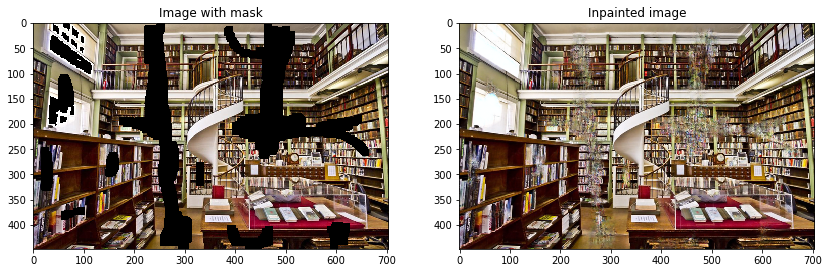



100%|█████████▉| 3991/4000 [21:22<00:04,  2.10it/s]

100%|█████████▉| 3993/4000 [21:22<00:02,  2.60it/s]

100%|█████████▉| 3994/4000 [21:22<00:02,  2.82it/s]

100%|█████████▉| 3995/4000 [21:23<00:01,  2.99it/s]

100%|█████████▉| 3996/4000 [21:23<00:01,  3.13it/s]

100%|█████████▉| 3997/4000 [21:23<00:00,  3.22it/s]

100%|█████████▉| 3998/4000 [21:23<00:00,  3.29it/s]

100%|█████████▉| 3999/4000 [21:24<00:00,  3.34it/s]

100%|██████████| 4000/4000 [21:24<00:00,  3.11it/s]


In [17]:
img = cv2.imread('./data/inpainting/library.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
mask = cv2.imread('./data/inpainting/library_mask.png')
model = Unet(n_base_channels=128)
model.to(device)
train(model, img, mask)

In [14]:
class Unet(nn.Module):
    def __init__(self, n_base_channels=128):
        super().__init__()
        self.down_blocks = nn.ModuleList([
            UnetDownBlock(3, n_base_channels),
            UnetDownBlock(n_base_channels, n_base_channels),
            UnetDownBlock(n_base_channels, n_base_channels),
            UnetDownBlock(n_base_channels, n_base_channels),
            UnetDownBlock(n_base_channels, n_base_channels),
            UnetDownBlock(n_base_channels, n_base_channels)
        ])
        self.up_blocks = nn.ModuleList([
            UnetUpBlock(n_base_channels, n_base_channels),
            UnetUpBlock(n_base_channels, n_base_channels),
            UnetUpBlock(n_base_channels, n_base_channels),
            UnetUpBlock(n_base_channels, n_base_channels),
            UnetUpBlock(n_base_channels, n_base_channels),
        ])
        self.final_block = nn.Sequential(
            # this block is modified. didn't work without it
            nn.Conv2d(n_base_channels, n_base_channels, kernel_size=5, padding=2),
            nn.LeakyReLU(),
            nn.Conv2d(n_base_channels, 3, kernel_size=3, padding=1),
            nn.Sigmoid())

        
    def forward(self, x):
        out = x
        outputs_before_pooling = []
        for i, block in enumerate(self.down_blocks):
            out, before_pooling = block(out)
            outputs_before_pooling.append(before_pooling)
        out = before_pooling
        
        for i, block in enumerate(self.up_blocks):
            out = block(out, outputs_before_pooling[-i - 2])
        out = self.final_block(out)
        
        return out

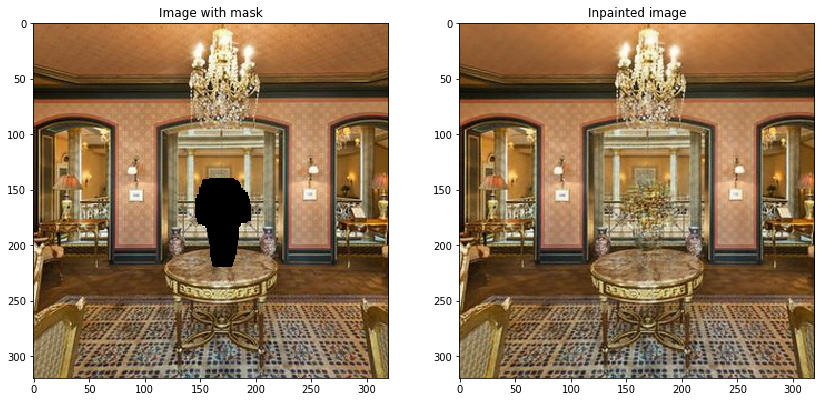







 99%|█████████▉| 991/1000 [03:53<00:03,  2.79it/s]





 99%|█████████▉| 992/1000 [03:53<00:02,  3.30it/s]





 99%|█████████▉| 993/1000 [03:53<00:01,  3.60it/s]





 99%|█████████▉| 994/1000 [03:53<00:01,  3.78it/s]





100%|█████████▉| 995/1000 [03:54<00:01,  4.09it/s]





100%|█████████▉| 996/1000 [03:54<00:00,  4.34it/s]





100%|█████████▉| 997/1000 [03:54<00:00,  4.54it/s]





100%|█████████▉| 998/1000 [03:54<00:00,  4.69it/s]





100%|█████████▉| 999/1000 [03:54<00:00,  4.81it/s]





100%|██████████| 1000/1000 [03:55<00:00,  4.25it/s]


In [16]:
device = torch.device("cuda")
img = cv2.imread('./data/inpainting/vase.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
mask = cv2.imread('./data/inpainting/vase_mask.png')
model = Unet(128)
model.to(device)
train(model, img, mask, n_epochs=1000)

# Part 3. Variational Autoencoder (VAE) — 15 points

Useful links: 
* Original paper http://arxiv.org/abs/1312.6114
* Helpful videos explaining the topic 
   * https://www.youtube.com/watch?v=P78QYjWh5sM     
   * http://videolectures.net/deeplearning2015_courville_autoencoder_extension/?q=aaron%20courville

In this homework we will train an autoencoder to model images of faces. For this we take "Labeled Faces in the Wild" dataset (LFW) (http://vis-www.cs.umass.edu/lfw/), deep funneled version of it. (frontal view of all faces)


### Prepare the data

In [17]:
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils
import matplotlib.pyplot as plt
%matplotlib inline

In [18]:
# !wget https://raw.githubusercontent.com/yandexdataschool/Practical_DL/hw3_19/homework03/lfw_dataset.py -O lfw_dataset.py

In [19]:
#@title Utility functions
import numpy as np
import os
import skimage.io
import skimage
import skimage.transform
import pandas as pd

def fetch_lfw_dataset(attrs_name = "lfw_attributes.txt",
                      images_name = "lfw-deepfunneled",
                      raw_images_name = "lfw",
                      use_raw=False,
                      dx=80,dy=80,
                      dimx=45,dimy=45
    ): # sad smile

    #download if not exists
    if (not use_raw) and not os.path.exists(images_name):
        print("images not found, donwloading...")
        os.system("wget http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz -O tmp.tgz")
        print("extracting...")
        os.system("tar xvzf tmp.tgz && rm tmp.tgz")
        print("done")
        assert os.path.exists(images_name)
    
    if use_raw and not os.path.exists(raw_images_name):
        print("images not found, donwloading...")
        os.system("wget http://vis-www.cs.umass.edu/lfw/lfw.tgz -O tmp.tgz")
        print("extracting...")
        os.system("tar xvzf tmp.tgz && rm tmp.tgz")
        print("done")
        assert os.path.exists(raw_images_name)

    if not os.path.exists(attrs_name):
        print("attributes not found, downloading...")
        os.system("wget http://www.cs.columbia.edu/CAVE/databases/pubfig/download/%s" % attrs_name)
        print("done")

    #read attrs
    df_attrs = pd.read_csv("lfw_attributes.txt",sep='\t',skiprows=1,) 
    df_attrs = pd.DataFrame(df_attrs.iloc[:,:-1].values, columns = df_attrs.columns[1:])


    #read photos
    dirname = raw_images_name if use_raw else images_name
    photo_ids = []
    for dirpath, dirnames, filenames in os.walk(dirname):
        for fname in filenames:
            if fname.endswith(".jpg"):
                fpath = os.path.join(dirpath,fname)
                photo_id = fname[:-4].replace('_',' ').split()
                person_id = ' '.join(photo_id[:-1])
                photo_number = int(photo_id[-1])
                photo_ids.append({'person':person_id,'imagenum':photo_number,'photo_path':fpath})

    photo_ids = pd.DataFrame(photo_ids)

    #mass-merge
    #(photos now have same order as attributes)
    df_attrs['imagenum'] = df_attrs['imagenum'].astype(np.int64)
    df = pd.merge(df_attrs, photo_ids, on=('person','imagenum'))

    assert len(df)==len(df_attrs),"lost some data when merging dataframes"

    #image preprocessing
    all_photos = df['photo_path'].apply(lambda img: skimage.io.imread(img))\
                                 .apply(lambda img:img[dy:-dy,dx:-dx])\
                                 .apply(lambda img: skimage.img_as_ubyte(skimage.transform.resize(img,[dimx,dimy])))

    all_photos = np.stack(all_photos.values).astype('uint8')
    all_attrs = df.drop(["photo_path","person","imagenum"],axis=1)
    
    return all_photos,all_attrs

In [20]:
data,attrs = fetch_lfw_dataset(dimx=36,dimy=36)

/home/topshik/.local/lib/python3.6/site-packages/skimage/util/dtype.py:135: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


In [21]:
data = data/255
np.savez("real.npz", Pictures=data.reshape(data.shape[0], 36*36*3))

In [22]:
X_train = data[:10000].reshape((10000, -1))
print(X_train.shape)
X_val = data[10000:].reshape((-1, X_train.shape[1]))
print(X_val.shape)

image_h = data.shape[1]
image_w = data.shape[2]

(10000, 3888)
(3143, 3888)


For simplicity we want all values of the data to lie in the interval $[0,1]$:

In [23]:
X_train = np.float32(X_train)
X_val = np.float32(X_val)

In [24]:
def plot_gallery(images, h, w, n_row=3, n_col=6):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.5 * n_col, 1.7 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w, 3)), cmap=plt.cm.gray, vmin=-1, vmax=1, interpolation='nearest')
        plt.xticks(())
        plt.yticks(())

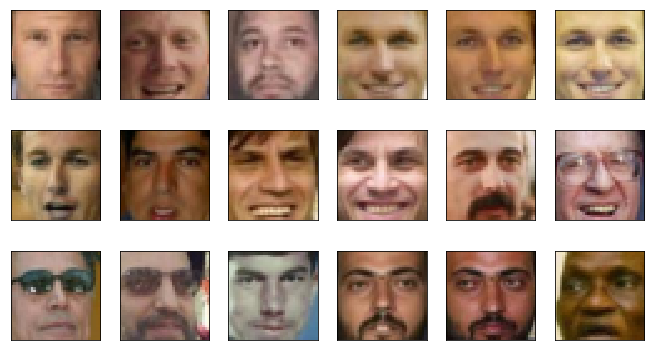

In [25]:
plot_gallery(X_train, image_h, image_w)

In [26]:
train = data_utils.TensorDataset(torch.Tensor(X_train), torch.zeros(X_train.shape[0],)) # pseudo labels needed to define TensorDataset
train_loader = data_utils.DataLoader(train, batch_size=100, shuffle=True)

val = data_utils.TensorDataset(torch.Tensor(X_val), torch.zeros(X_val.shape[0],))
val_loader = data_utils.DataLoader(val, batch_size=1, shuffle=False)

## Autoencoder

Why to use all this complicated formulas and regularizations, what is the need for variational inference? To analyze the difference, let's first train just an autoencoder on the data:

<img src="https://lilianweng.github.io/lil-log/assets/images/autoencoder-architecture.png" alt="Autoencoder">

In [27]:
dimZ = 100 # Considering face reconstruction task, which size of representation seems reasonable?

# Define the decoder and encoder as networks with one hidden fc-layer
# (that means you will have 2 fc layers in each net)
# Use ReLU for hidden layers' activations
# GlorotUniform initialization for W
# Zero initialization for biases
# It's also convenient to put sigmoid activation on output layer to get nice normalized pics

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        
        #TODO
        
        self.encoder = nn.Sequential(nn.Linear(3888, 2000),
                                     nn.ReLU(),
                                     nn.Linear(2000, dimZ))
        self.decoder = nn.Sequential(nn.Linear(dimZ, 2000),
                                     nn.ReLU(),
                                     nn.Linear(2000, 3888),
                                     nn.Sigmoid())
        torch.nn.init.xavier_uniform_(self.encoder[0].weight.data)
        torch.nn.init.xavier_uniform_(self.encoder[2].weight.data)
        torch.nn.init.xavier_uniform_(self.decoder[0].weight.data)
        torch.nn.init.xavier_uniform_(self.decoder[0].weight.data)
        torch.nn.init.zeros_(self.encoder[0].bias.data)
        torch.nn.init.zeros_(self.encoder[2].bias.data)
        torch.nn.init.zeros_(self.decoder[0].bias.data)
        torch.nn.init.zeros_(self.decoder[2].bias.data)
        
    def forward(self, x):
        
        #TODO
        
        latent_code = self.encoder(x)
        reconstruction = self.decoder(latent_code)
        
        return reconstruction, latent_code

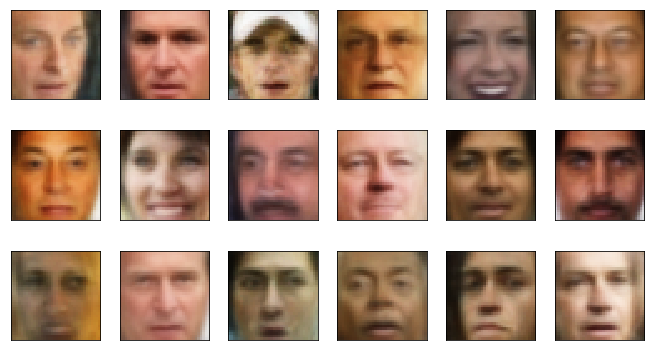

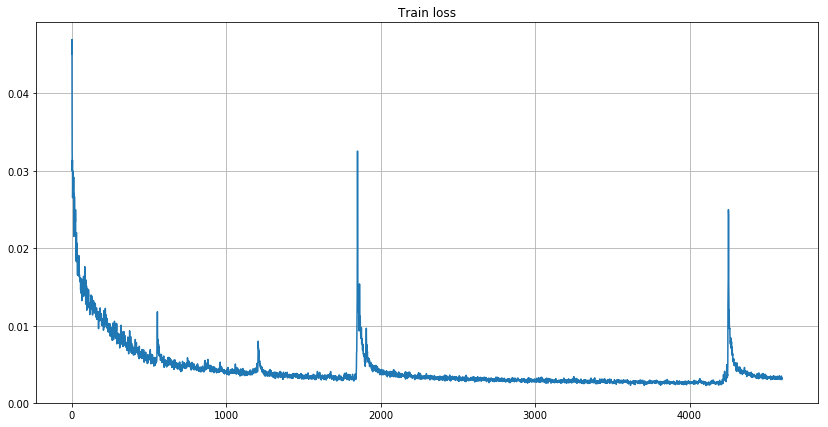

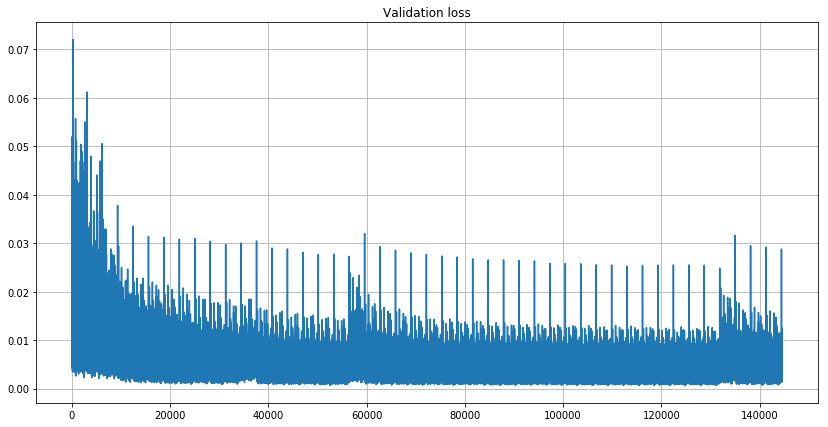








 92%|█████████▏| 46/50 [01:28<00:08,  2.16s/it]






 94%|█████████▍| 47/50 [01:30<00:06,  2.07s/it]






 96%|█████████▌| 48/50 [01:32<00:04,  2.00s/it]






 98%|█████████▊| 49/50 [01:34<00:01,  1.95s/it]






100%|██████████| 50/50 [01:36<00:00,  1.92s/it]


In [30]:
# Train your autoencoder
# Visualize progress in reconstruction and loss decay
def train(model, train_loader, val_loader, n_epochs=50):
    criterion = torch.nn.MSELoss()
    optimizer = optim.Adam(model.parameters())
    putins, train_loss_hist, val_loss_hist = [], [], []
    model.train()
    for i in tqdm(range(n_epochs)):
        for j, (batch, _) in enumerate(train_loader):
            batch = batch.cuda()
            reconstructions, latent_codes = model(batch)
            loss = criterion(reconstructions, batch)
            loss.backward()
            train_loss_hist.append(loss.item())
            optimizer.step()
            optimizer.zero_grad()
            
        model.eval()
        for j, (batch, _) in enumerate(val_loader):
            batch = batch.cuda()
            reconstruction, latent_code = model(batch)
            if j == 2754:
                putins.append(reconstruction)
            loss = criterion(reconstruction, batch)
            val_loss_hist.append(loss.item())
                
        if i % 15 == 0:
            display.clear_output()
            plot_gallery(reconstructions.detach().cpu().numpy(), image_h, image_w)    
            plt.figure(figsize=(14, 7))
            plt.title('Train loss')
            plt.plot(train_loss_hist)
            plt.grid()
            plt.show()
            plt.figure(figsize=(14, 7))
            plt.title('Validation loss')
            plt.plot(val_loss_hist)
            plt.grid()
            plt.show()
    return putins

autoencoder = Autoencoder().cuda()
image_progress = train(autoencoder, train_loader, val_loader)

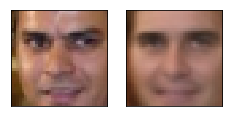

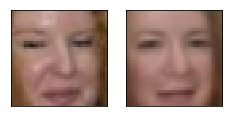

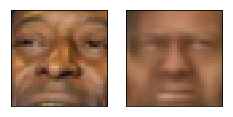

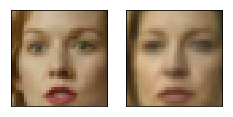

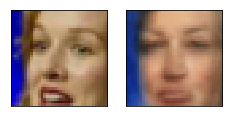

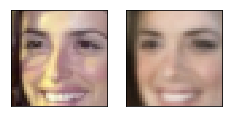

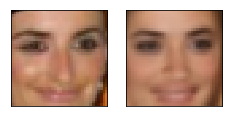

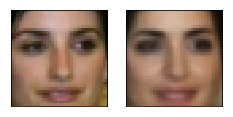

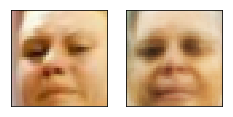

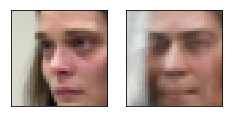

In [31]:
# Examine the reconstructions
for j, data in enumerate(val_loader, 0):
    inp = data[0].cuda()
    pred, _ = autoencoder(inp)
    plot_gallery([data[0].numpy(), pred.data.cpu().numpy()], image_h, image_w, n_row=1, n_col=2)
    if (j >= 9):
        break

Reconstruction is not bad, right? 

## Sampling

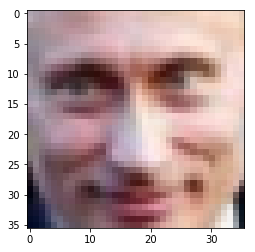

In [32]:
for i, (putin, y) in enumerate(val_loader):
    if i == 2754:
        break
plt.imshow(putin.numpy().reshape((image_w, image_w, 3)))

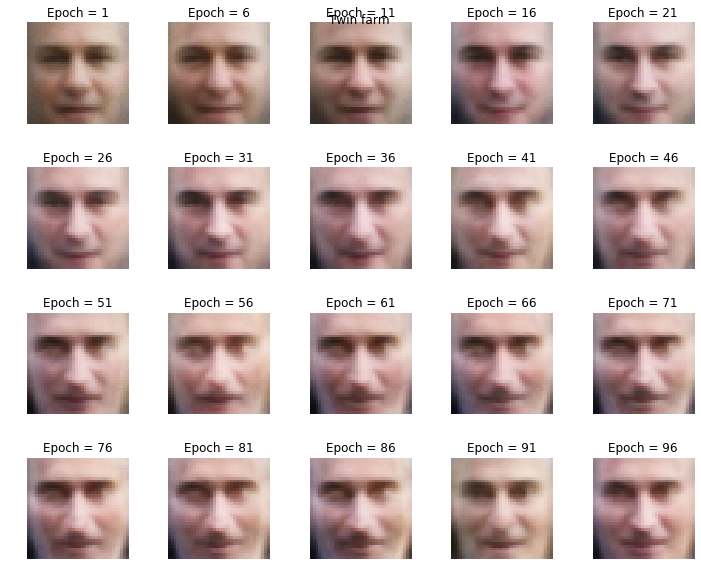

In [33]:
plt.figure(figsize=(10, 12))
plt.suptitle('Twin farm')
for i in range(len(image_progress[:20])):
    plt.subplots_adjust(bottom=0.0, left=.1, right=.9, top=.50, hspace=.15)
    plt.subplot(6, 5, 5*(i//5) + i % 5 + 1)
    plt.imshow(image_progress[i].clamp(0,1).data.cpu().numpy().reshape(image_w, image_h, 3))
    plt.title('Epoch = {}'.format(i * 5 + 1))
    plt.axis('off')
plt.tight_layout()

I saw some of them on TV...

Let's now sample several latent vectors and perform inference from $z$, reconstruct an image given some random $z$ representations.

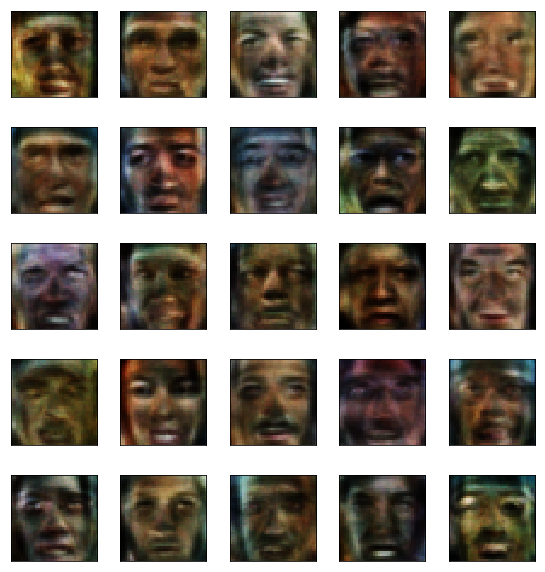

In [34]:
z = (np.random.randn(25, dimZ)*0.5).astype('float32')
output = autoencoder.decoder(torch.from_numpy(z).cuda()).clamp(0, 1)
plot_gallery(output.data.cpu().numpy(), image_h, image_w, n_row=5, n_col=5)

So, if we sample $z$ from normal, whould we eventually generate all possible faces? What do you think?

## Variational Autoencoder

Bayesian approach in deep learning considers everything in terms of distributions. Now our encoder generates not just a vector $z$ but posterior ditribution $q(z|x)$. In our case distribution $q$ is Gaussian distibution $N(\mu, \sigma)$ with parameters $\mu$, $\sigma$. Technically, the first difference is that you need to split bottleneck layer in two. One dense layer will generate vector $\mu$, and another will generate vector $\sigma$. Reparametrization trick should be implemented using the **gaussian_sampler** layer, that generates random vetor $\epsilon$ and returns $\mu+\sigma\epsilon \sim N(\mu, \sigma)$ .

Since our decoder is also a function that generates distribution, we need to do the same splitting for output layer. When testing the model we will look only on mean values, so one of the output will be actual autoencoder output.

In this homework we only ask for implementation of the simplest version of VAE - one $z$ sample per input. You can consider to sample several outputs from one input and average them.

In [61]:
# to compare with conventional AE, keep these hyperparameters
# or change them for the values that you used before
dimZ = 100

# define the network
# you can start from https://github.com/pytorch/examples/blob/master/vae/main.py
# or Theano-based examples here https://github.com/Lasagne/Recipes/blob/master/examples/variational_autoencoder/variational_autoencoder.py
# and here https://github.com/y0ast/Variational-Autoencoder/blob/master/VAE.py
# but remember that this is not your ground truth since the data is not MNIST

class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        
        #TODO
        self.fc1 = nn.Linear(3888, 2000)
        self.fc2_mu = nn.Linear(2000, dimZ)
        self.fc2_sigma = nn.Linear(2000, dimZ)
        self.fc3 = nn.Linear(dimZ, 2000)
        self.fc4_mu = nn.Linear(2000, 3888)
        self.fc4_sigma = nn.Linear(2000, 3888)
    
    
    def gaussian_sampler(self, mu, logsigma):
        if self.training:
            std = logsigma.exp()
            eps = std.data.new(std.size()).normal_()
            return eps.mul(std).add(mu)
        else:
            return mu
        
        
    def decode(self, z):
        out = nn.ReLU()(self.fc3(z))
        return nn.Sigmoid()(self.fc4_mu(out)), nn.Sigmoid()(self.fc4_sigma(out))
    

    def forward(self, x):
        
        #TODO
        # return reconstruction_mu, reconstruction_logsigma, latent_mu, latent_logsigma
        h1 = nn.ReLU()(self.fc1(x))
        latent_mu, latent_logsigma = self.fc2_mu(h1), self.fc2_sigma(h1)
        z = self.gaussian_sampler(latent_mu, latent_logsigma)
        h2 = nn.ReLU()(self.fc3(z))
        reconstruction_mu, reconstruction_logsigma = nn.Sigmoid()(self.fc4_mu(h2)), nn.Sigmoid()(self.fc4_sigma(h2))
        return reconstruction_mu, reconstruction_logsigma, latent_mu, latent_logsigma

And the last, but not least! Place in the code where the most of the formulaes goes to - optimization objective. The objective for VAE has it's own name - variational lowerbound. And as for any lowerbound our intention is to maximize it. Here it is (for one sample $z$ per input $x$):

$$\mathcal{L} = -D_{KL}(q_{\phi}(z|x)||p(z)) + \log p_{\theta}(x|z)$$

Your next task is to implement two functions that compute KL-divergence and the second term - log-likelihood of an output. Here is some necessary math for your convenience:

$$D_{KL} = -\frac{1}{2}\sum_{i=1}^{dimZ}(1+log(\sigma_i^2)-\mu_i^2-\sigma_i^2)$$
$$\log p_{\theta}(x|z) = \sum_{i=1}^{dimX}\log p_{\theta}(x_i|z)=\sum_{i=1}^{dimX} \log \Big( \frac{1}{\sigma_i\sqrt{2\pi}}e^{-\frac{(\mu_i-x)^2}{2\sigma_i^2}} \Big)=...$$

Don't forget in the code that you are using $\log\sigma$ as an input. Explain, why not $\sigma$?

In [62]:
def KL_divergence(mu, logsigma):
    return -(1 + 2 * logsigma - mu ** 2 - logsigma.exp() ** 2).sum() / 2
    

def log_likelihood(x, mu, logsigma):
    return torch.distributions.normal.Normal(mu, logsigma.exp()).log_prob(x).sum()


def loss_vae(x, mu_gen, logsigma_gen, mu_z, logsigma_z):
    return KL_divergence(mu_z, logsigma_z) - log_likelihood(x, mu_gen, logsigma_gen)

And train the model:

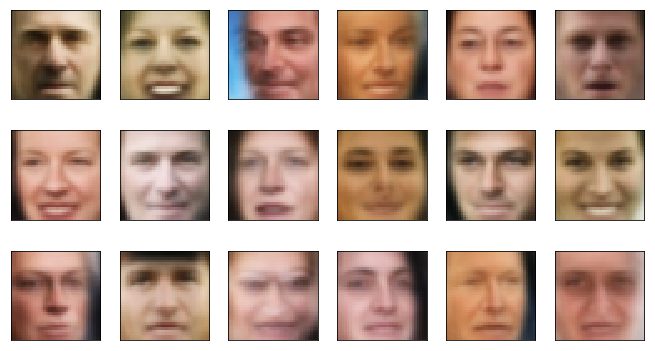

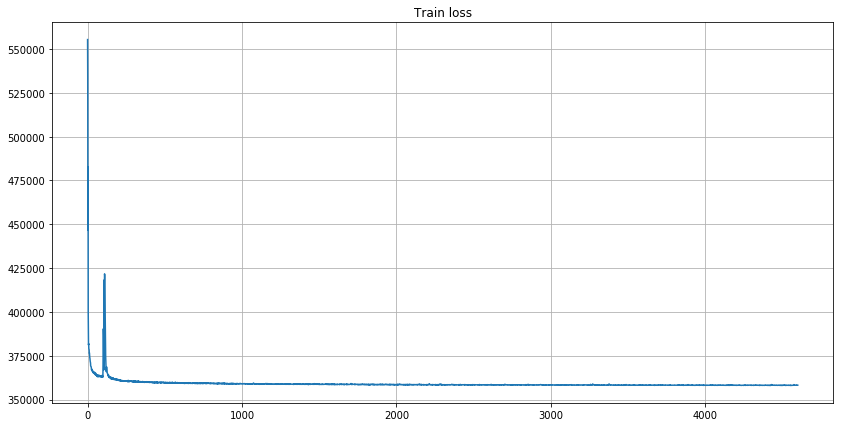

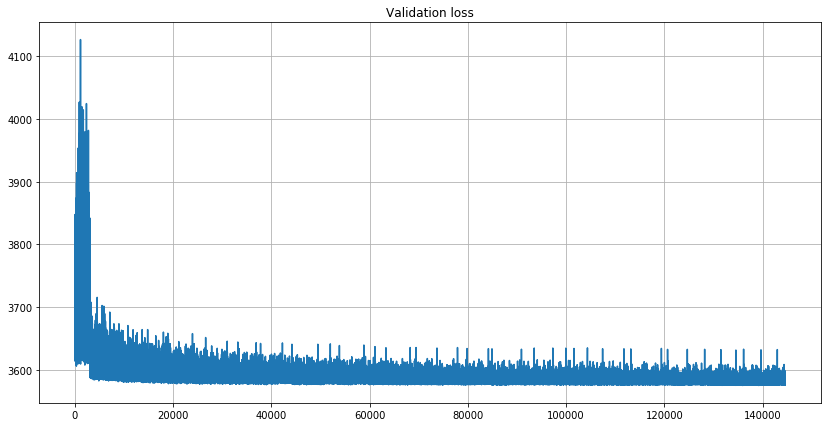











 92%|█████████▏| 46/50 [03:02<00:18,  4.55s/it]









 94%|█████████▍| 47/50 [03:06<00:12,  4.30s/it]









 96%|█████████▌| 48/50 [03:10<00:08,  4.12s/it]









 98%|█████████▊| 49/50 [03:14<00:04,  4.12s/it]









100%|██████████| 50/50 [03:19<00:00,  3.99s/it]


In [63]:
# train your autoencoder
# visualize progress in reconstruction and loss decay
def train(model, train_loader, val_loader, n_epochs=50):
    criterion = loss_vae
    optimizer = optim.Adam(model.parameters())
    putins, train_loss_hist, val_loss_hist = [], [], []
    model.train()
    for i in tqdm(range(n_epochs)):
        for j, (batch, _) in enumerate(train_loader):
            batch = batch.cuda()
            mu_gen, logsigma_gen, mu_z, logsigma_z = model(batch)
            reconstructions = mu_gen
            loss = criterion(batch, mu_gen, logsigma_gen, mu_z, logsigma_z)
            loss.backward()
            train_loss_hist.append(loss.item())
            optimizer.step()
            optimizer.zero_grad()
            
        model.eval()
        for j, (batch, _) in enumerate(val_loader):
            batch = batch.cuda()
            mu_gen, logsigma_gen, mu_z, logsigma_z = model(batch)
            loss = criterion(batch, mu_gen, logsigma_gen, mu_z, logsigma_z)
            val_loss_hist.append(loss.item())
                
        if i % 15 == 0:
            display.clear_output()
            plot_gallery(reconstructions.detach().cpu().numpy(), image_h, image_w)    
            plt.figure(figsize=(14, 7))
            plt.title('Train loss')
            plt.plot(train_loss_hist)
            plt.grid()
            plt.show()
            plt.figure(figsize=(14, 7))
            plt.title('Validation loss')
            plt.plot(val_loss_hist)
            plt.grid()
            plt.show()
    return putins

autoencoder = VAE().cuda()
image_progress = train(autoencoder, train_loader, val_loader)

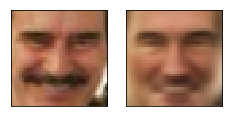

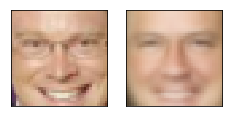

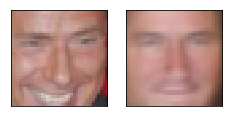

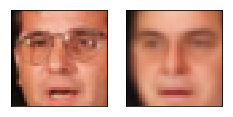

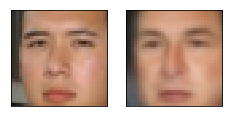

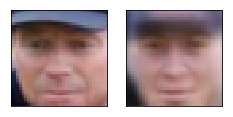

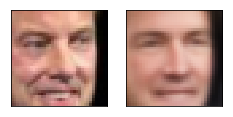

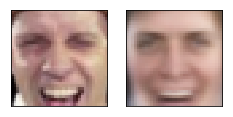

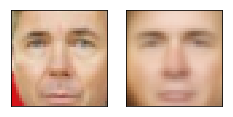

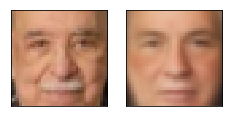

In [64]:
vae = autoencoder
val_loader = data_utils.DataLoader(val, batch_size=1, shuffle=True)
vae.eval()
for j, data in enumerate(val_loader, 0):
    input = data[0].cuda()
    reconstruction_mu, _, _, _ = vae(input)
    plot_gallery([data[0].numpy(), reconstruction_mu.data.cpu().numpy()], image_h, image_w, n_row=1, n_col=2)
    if (j >= 9):
        break

And finally sample from VAE.

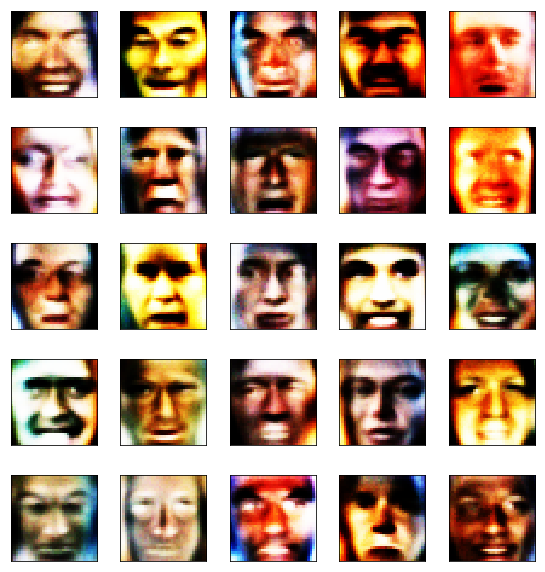

In [65]:
# TODO
# Sample some images from the learned distribution
# 1) Sample z ~ N(0,1)
# 2) Sample from N(decoder_mu(z), decoder_sigma(z))
z = (np.random.randn(25, dimZ)).astype('float32')
output, _ = vae.decode(torch.from_numpy(z).cuda())
output = output.clamp(0, 1)
plot_gallery(output.data.cpu().numpy(), image_h, image_w, n_row=5, n_col=5)

Even if in practice you do not see the much difference between AE and VAE, or VAE is even worse, the little bayesian inside you should be jumping for joy right now. 

In VAE you can truly sample from image distribution $p(x)$, while in AE there is no easy and correct way to do it. 

## Congrats! and Bonus

If you managed to tune your autoencoders to converge and learn something about the world, now it's time to make fun out of it. As you may have noticed, there are face attributes in dataset. We're interesting in "Smiling" column, but feel free to try others as well! Here is the first task:

1) Extract the "Smilling" attribute and create a two sets of images: 10 smiling faces and 10 non-smiling ones.

2) Compute latent representations for each image in "smiling" set and average those latent vectors. Do the same for "non-smiling" set. You have found **"vector representation"** of the "smile" and "no smile" attribute.

3) Compute the difference: "smile" vector minus "non-smile" vector.

3) Now check if **"feature arithmetics"** works. Sample a face without smile, encode it and add the diff from p. 3. Check if it works with both AE and VAE. 

In [ ]:
# TODO

# Part 4. Generative Adversarial Networks (GANs) — 15 points

## Links

- https://en.wikipedia.org/wiki/Generative_adversarial_network
- https://towardsdatascience.com/understanding-generative-adversarial-networks-gans-cd6e4651a29

## Theory

### Intro

Now we will consider another implicit generative model.

Implicit models (in contrary to explicit VAE), do not provide a direct access to the modeled data distribution $p(x)$, but only allow to sample from it.

Though this may be an advantage rather than a disadvantage. Most of the explicit models have to make assumptions about the shape of the data distribution. For example, in VAEs the assumption is that each image comes from a normal distribution, with each pixel being _independent_ of each other. Needless to say, this model is far from being ideal for modelling the natural images, because we all know that pixels in the image strongly depend not only on their neighbours, but sometimes on the global context as well.

<img src="https://bit.ly/3567LM6" width=320px>

This is why it is hard for us to believe that the image above is real, even though all local patches are perfectly real :)

### Method description

In order to overcome limitations of tracktable families of probabilistic models, we have to go intractable. Currently, Generative Adversarial Networks is the most successful example of such models.

__Key idea__ of GANs is the use of a loss function that is trained from the data.

A good analogy is a counterfeiter vs a cop example:

<img src="https://www.cfml.se/img/blog/generative_adversarial_networks/counterfeiter_vs_cop.jpg" width=640px>

A counterfeiter is a "generator" neural network that is being trained to produce realistic data points (not neccessarily images). A cop is a "discriminator" neural network trained to recognize fake data points. The counterfeiter gets constant updates from the cop via a gradient flow (backpropagation) and tries to maximize the realism score a cop is assigning to fake data points. The cop receives the feedback via the update of the available dataset, and tries to maximize the recognition accuracy.

If we denote $G$ as a generator, with $\hat{x}$ being its output, $D$ as a discriminator and $\mathcal{L}(s, \hat{s})$ as a classification function (with $s$ denoting class scores) the cop would want to minimize (say, binary cross entropy), then the objective can be written as a zero-sum game (since a classification function is typically symmetric w.r.t. classes): 

$$
    \max_G \min_D \mathcal{L} \big( D(x), D(\hat{x}) \big).
$$

In practice, however, for numerous reasons it is useful to separate this single objective into two, leading to a potentially non-zero sum game:

$$
    \max_G \min_D \mathcal{L}_G \big( D(x), D(\hat{x}) \big) + \mathcal{L}_D ( D(x), D(\hat{x}) \big),
$$

with gradients from the objective $\mathcal{L}_G$ being back-propagated only into the generator, and $\mathcal{L}_D$ — only into the discriminator.

### Training stability

The objective above is typically optimized via an alternating stochastic gradient descend technique: i.e., we first do an optimization step w.r.t. one network, and then use updated weights to perform a step w.r.t. another network. Although this technique has convergence issues [1], it is still widely used for its simplicity and memory efficiency.

Also, although GANs used to be notoriously hard to train, a number of techniques [2, 3] have been developed to overcome the difficulties.

Still, when we are talking about GANs, it is incorrect to use a term "convergence", because even with the aforementioned techniques, the optimization process does not converge to a state when the loss of the generator converges to zero. On contrary, it is a __red flag__ indicating a __training instability__ if this loss converges to zero. In practice, this means that the generator is fooling the discriminator with garbage.

Ideal training curves look like that:

<img src="https://i.ibb.co/0csVDhH/gans-training-curves.png" alt="source: https://deepai.org/publication/geogan-a-conditional-gan-with-reconstruction-and-style-loss-to-generate-standard-layer-of-maps-from-satellite-images" width=640px>

Bad training curves look like that:

<img src="https://miro.medium.com/max/2732/1*4A5bo8gVG9wmg-5wtqavOg.png" width=640px>

The weights of both the generator and discriminator keep constantly updating during training, resulting in a typical oscilation behavior [1].

Usually ideal training curves end up like the bad ones if you train long enough — all you can do is taking a checkpoint right before the training collapses (you can see this point clearly on the second plot). If the training process was stable, this collapse happends long after the results have stopped improving, though some models still struggle to obtain stable enough behavior for data with high dimensionality [4].

## Task

Implement and train a generative adversarial network using the provided dataset in 3 variants:

1. with a spectral normalization,
2. with a gradient penalty,
3. without any regularization.

Also try turning on and off batch normalization in the generator network for all approaches. Note that spectral normalization and batch normalization can be used simultaneously, since SN is only applied to linear and convolutional layers.

Visualize the resulting learning curves for all approaches and provide a side-by-side comparison for a small (~10 items) subset of samples for each method. Your learning curves should look similar to the "ideal" curves above.

## Notes

- Use Adam optimizer with $\beta_1 = 0$ for both the generator and the discriminator.
- Start with the learning rate equal to $1 \cdot 10^{-4}$ for both networks. Increase the learning rate by a factor of 4 for the discriminator, when using spectral normalization.
- Use PyTorch implementation of spectral normalization (__torch.nn.utils.SpectralNorm__). Implement a gradient penalty by hand using the following equations and __torch.autograd.grad__ (pass discriminator outputs to _outputs_, inputs to _inputs_, and ones to grad_outputs, set _retain_graph_ to True):


$$
    \mathcal{L}_\text{GP} = 10 \cdot \mathbb{E}_{x \sim p(x)} (||\nabla_x D(x)||_2 - 1)^2
$$

- Use hinge loss for training, but feel free to experiment with other losses as well for bonus points.

\begin{aligned}
    & \mathcal{L}_D = \mathbb{E}_{x \sim p(x)}\, \text{min}\big( 0, 1 - D(x) \big) + \mathbb{E}_{z \sim p(z)}\, \text{min}\big( 0, 1 + D(G(z)) \big) \\
    & \mathcal{L}_G = - \mathbb{E}_{z \sim p(z)}\, D(G(z))
\end{aligned}

## References

[1] Mescheder et. al., "Which Training Methods for GANs do actually Converge?", ICML 2018, https://arxiv.org/abs/1801.04406

[2] Miyato et. al., "Spectral Normalization for Generative Adversarial Networks", ICLR 2018, https://arxiv.org/abs/1802.05957

[3] Gulrajani et. al., "Improved Training of Wasserstein GANs", NeurIPS 2017, https://arxiv.org/abs/1704.00028

[4] Brock et. al., "Large Scale GAN Training for High Fidelity Natural Image Synthesis", ICLR 2018, https://arxiv.org/abs/1809.11096

In [1]:
#@title Utility functions
import numpy as np
import os
import skimage.io
import skimage
import skimage.transform
import pandas as pd
from IPython import display
from tqdm import tqdm

def fetch_lfw_dataset(attrs_name = "lfw_attributes.txt",
                      images_name = "lfw-deepfunneled",
                      raw_images_name = "lfw",
                      use_raw=False,
                      dx=80,dy=80,
                      dimx=45,dimy=45
    ): # sad smile

    #download if not exists
    if (not use_raw) and not os.path.exists(images_name):
        print("images not found, donwloading...")
        os.system("wget http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz -O tmp.tgz")
        print("extracting...")
        os.system("tar xvzf tmp.tgz && rm tmp.tgz")
        print("done")
        assert os.path.exists(images_name)
    
    if use_raw and not os.path.exists(raw_images_name):
        print("images not found, donwloading...")
        os.system("wget http://vis-www.cs.umass.edu/lfw/lfw.tgz -O tmp.tgz")
        print("extracting...")
        os.system("tar xvzf tmp.tgz && rm tmp.tgz")
        print("done")
        assert os.path.exists(raw_images_name)

    if not os.path.exists(attrs_name):
        print("attributes not found, downloading...")
        os.system("wget http://www.cs.columbia.edu/CAVE/databases/pubfig/download/%s" % attrs_name)
        print("done")

    #read attrs
    df_attrs = pd.read_csv("lfw_attributes.txt",sep='\t',skiprows=1,) 
    df_attrs = pd.DataFrame(df_attrs.iloc[:,:-1].values, columns = df_attrs.columns[1:])


    #read photos
    dirname = raw_images_name if use_raw else images_name
    photo_ids = []
    for dirpath, dirnames, filenames in os.walk(dirname):
        for fname in filenames:
            if fname.endswith(".jpg"):
                fpath = os.path.join(dirpath,fname)
                photo_id = fname[:-4].replace('_',' ').split()
                person_id = ' '.join(photo_id[:-1])
                photo_number = int(photo_id[-1])
                photo_ids.append({'person':person_id,'imagenum':photo_number,'photo_path':fpath})

    photo_ids = pd.DataFrame(photo_ids)

    #mass-merge
    #(photos now have same order as attributes)
    df_attrs['imagenum'] = df_attrs['imagenum'].astype(np.int64)
    df = pd.merge(df_attrs, photo_ids, on=('person','imagenum'))

    assert len(df)==len(df_attrs),"lost some data when merging dataframes"

    #image preprocessing
    all_photos = df['photo_path'].apply(lambda img: skimage.io.imread(img))\
                                 .apply(lambda img:img[dy:-dy,dx:-dx])\
                                 .apply(lambda img: skimage.img_as_ubyte(skimage.transform.resize(img,[dimx,dimy])))

    all_photos = np.stack(all_photos.values).astype('uint8')
    all_attrs = df.drop(["photo_path","person","imagenum"],axis=1)
    
    return all_photos,all_attrs

/home/topshik/.local/lib/python3.6/site-packages/skimage/util/dtype.py:135: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


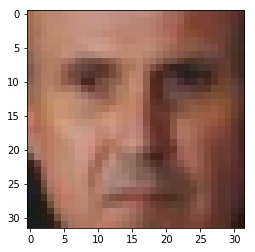

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
plt.rcParams.update({'axes.titlesize': 'small'})

# The following line fetches you two datasets: images, usable for autoencoder training and attributes.
# Those attributes will be required for the final part of the assignment (applying smiles), so please keep them in mind
data,attrs = fetch_lfw_dataset(dimx=32, dimy=32)

# Preprocess faces
data = np.float32(data).transpose([0, 3, 1, 2]) / 127.5 - 1.0

IMG_SHAPE = data.shape[1:]

# Print random image
plt.imshow(((data[np.random.randint(data.shape[0])] + 1) / 2.0).transpose([1, 2, 0]),
           cmap="gray", interpolation="none")

In [3]:
import torch, torch.nn as nn
import torch.nn.functional as F

use_cuda = torch.cuda.is_available()

print("Torch version:", torch.__version__)
if use_cuda:
    print("Using GPU")
else:
    print("Not using GPU")

Torch version: 1.5.0
Using GPU


In [4]:
def sample_noise_batch(batch_size):
    noise = torch.randn(batch_size, CODE_SIZE)
    return noise.cuda() if use_cuda else noise.cpu()
    
class Reshape(nn.Module):
    def __init__(self, shape):
        nn.Module.__init__(self)
        self.shape=shape
    def forward(self,input):
        return input.view(self.shape)

### Generator

Example generator architecture is provided below: use it as a reference for you architectures, but feel free to experiment. If your experiments are shown to improve over baseline performance, you will be rewarded with bonus points.

In our realization, please insert batch normalization before nonlinearities.

In [5]:
CODE_SIZE = 256

from itertools import count
# automatic layer name maker. Don't do this in production :)
ix = ('layer_%i'%i for i in count())

generator = nn.Sequential(
    nn.Linear(CODE_SIZE, 256 * 4 * 4),
    Reshape([-1, 256, 4, 4]),
    nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
    nn.LeakyReLU(0.2),
    nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
    nn.LeakyReLU(0.2),
    nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
    nn.LeakyReLU(0.2),
    nn.Conv2d(32, 3, kernel_size=3, padding=1),
    nn.Tanh()
)

if use_cuda: generator.cuda()

In [6]:
generated_data = generator(sample_noise_batch(5))
assert tuple(generated_data.shape)[1:] == IMG_SHAPE, "generator must output an image of shape %s, but instead it produces %s" % (IMG_SHAPE,generated_data.shape)

### Discriminator
Discriminator is your usual convolutional network with interlooping convolution and pooling layers

The network does not include dropout/batchnorm to avoid learning complications.

The convolutional part of the discriminator should mirror the generator (with the exception of the first and the last layers).

In [7]:
def sample_data_batch(batch_size):
    idxs = np.random.choice(np.arange(data.shape[0]), size=batch_size)
    batch = torch.tensor(data[idxs], dtype=torch.float32)
    return batch.cuda() if use_cuda else batch.cpu()

# a special module that converts [batch, channel, w, h] to [batch, units]
class Flatten(nn.Module):
    def forward(self, input):
        return input.reshape(input.shape[0], -1)

In [26]:
discriminator = nn.Sequential(
    nn.Conv2d(3, 32, kernel_size=3, padding=1),
    nn.LeakyReLU(0.2),
    nn.Conv2d(32, 64, kernel_size=3, padding=1), 
    nn.LeakyReLU(0.2),
    nn.MaxPool2d(kernel_size=2),
    nn.Conv2d(64, 128, kernel_size=3, padding=1),
    nn.LeakyReLU(0.2),
    nn.MaxPool2d(kernel_size=2),
    nn.Conv2d(128, 256, kernel_size=3, padding=1),
    nn.LeakyReLU(0.2),
    nn.MaxPool2d(kernel_size=2),
    Flatten(),)

### YOUR CODE - create convolutional architecture for discriminator
### Note: please start simple. A few convolutions & poolings would do, inception/resnet is an overkill


discriminator.add_module("disc_logit", nn.Linear(4 * 4 * 256, 1))

if use_cuda: discriminator.cuda()

In [27]:
discriminator(sample_data_batch(5))

tensor([[-0.0282],
        [-0.0148],
        [-0.0046],
        [-0.0049],
        [-0.0095]], device='cuda:0', grad_fn=<AddmmBackward>)

In [47]:
# YOUR TRAINING CODE HERE
def plot_gallery(images):
    images = images.cpu().numpy()
    fig, axs = plt.subplots(1, len(images), figsize=[len(images) * 3, 3])
    for image, ax in zip(images, axs.ravel()):
        image = (image / 2 + 0.5).transpose([1, 2, 0]).clip(0, 1)
        ax.imshow(image)
    plt.show()

    
def build_gan(batchnorm=False, spectral=False):
    gen_blocks = []
    if not spectral:
        gen_blocks.append(nn.Sequential(
            nn.Linear(CODE_SIZE, 256 * 4 * 4),
            Reshape([-1, 256, 4, 4]),
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.LeakyReLU(0.2),))
        gen_blocks.append(nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.LeakyReLU(0.2),))
        gen_blocks.append(nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.LeakyReLU(0.2),))
    else:    
        gen_blocks.append(nn.Sequential(
            nn.Linear(CODE_SIZE, 256 * 4 * 4),
            Reshape([-1, 256, 4, 4]),
            nn.utils.spectral_norm(nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, 
                                                      padding=1, output_padding=1)),
            nn.LeakyReLU(0.2),))
        gen_blocks.append(nn.Sequential(
            nn.utils.spectral_norm(nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, 
                                                      padding=1, output_padding=1)),
            nn.LeakyReLU(0.2),))
        gen_blocks.append(nn.Sequential(
            nn.utils.spectral_norm(nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, 
                                                      padding=1, output_padding=1)),
            nn.LeakyReLU(0.2),))

    generator = nn.Sequential()
    for i in range(3):
        generator.add_module(str(i), gen_blocks[i])
        if batchnorm:
            generator.add_module(str(i) + '_bn', nn.BatchNorm2d(128 // 2 ** i))
    generator.add_module('last', nn.Sequential(nn.Conv2d(32, 3, kernel_size=3, padding=1),
                                               nn.Tanh()))
    disc_blocks = []
    if not spectral:
        disc_blocks.append(nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.LeakyReLU(0.2),))
        disc_blocks.append(nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1), 
            nn.LeakyReLU(0.2),))
        disc_blocks.append(nn.Sequential(
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.LeakyReLU(0.2),))
    else:    
        disc_blocks.append(nn.Sequential(
            nn.utils.spectral_norm(nn.Conv2d(3, 32, kernel_size=3, padding=1)),
            nn.LeakyReLU(0.2),))
        disc_blocks.append(nn.Sequential(
            nn.utils.spectral_norm(nn.Conv2d(32, 64, kernel_size=3, padding=1)), 
            nn.LeakyReLU(0.2),))
        disc_blocks.append(nn.Sequential(
            nn.MaxPool2d(kernel_size=2),
            nn.utils.spectral_norm(nn.Conv2d(64, 128, kernel_size=3, padding=1)),
            nn.LeakyReLU(0.2),))
    
    discriminator = nn.Sequential()
    for i in range(3):
        discriminator.add_module(str(i), disc_blocks[i])
        if batchnorm:
            discriminator.add_module(str(i) + '_bn', nn.BatchNorm2d(32 * 2 ** i))
    discriminator.add_module('last', nn.Sequential(nn.MaxPool2d(kernel_size=2),
                                               nn.Conv2d(128, 256, kernel_size=3, padding=1),
                                               nn.LeakyReLU(0.2),
                                               nn.MaxPool2d(kernel_size=2),
                                               Flatten(),
                                               nn.Linear(4 * 4 * 256, 1),))
    return generator, discriminator


def train(grad_penalty=0, batchnorm=True, spectral=False):
    batch_size = 512
    generator, discriminator = build_gan(batchnorm=batchnorm, spectral=spectral)
    device = torch.device('cuda')
    generator.to(device).train()
    discriminator.to(device).train()
    optimizer_d = torch.optim.Adam(discriminator.parameters(), betas=(0, 0.999))
    optimizer_g = torch.optim.Adam(generator.parameters(), betas=(0, 0.999))
    loader = torch.utils.data.DataLoader(torch.tensor(data), batch_size=batch_size, shuffle=True, num_workers=5)
    loss_d_hist = []
    loss_g_hist = []

    for i in tqdm(range(30)):
        for j, batch1 in enumerate(loader):
            batch1 = batch1.to(device).requires_grad_()
            batch2 = generator(sample_noise_batch(batch_size).cuda())
            preds1 = discriminator(batch1)
            preds2 = discriminator(batch2.detach())
            loss_d = torch.max(torch.zeros_like(preds1), 1 - preds1).mean() + torch.max(torch.zeros_like(preds2), 1 + preds2).mean()
            optimizer_d.zero_grad()
            
            if grad_penalty > 0:
                grad_norm = torch.autograd.grad(preds1, batch1, torch.ones_like(preds1), 
                                                retain_graph=True)[0].reshape(batch_size, -1).norm(dim=1)
                loss_d += grad_penalty * torch.mean((grad_norm - 1) ** 2)

            loss_d.backward()
            optimizer_d.step()
            loss_d_hist.append(loss_d.item())
            
            
            batch2 = generator(sample_noise_batch(batch_size))
            preds2 = discriminator(batch2)
            loss_g = -preds2.mean()
            optimizer_g.zero_grad()
            loss_g.backward()
            loss_g_hist.append(loss_g.item())
            optimizer_g.step()

        if i % 5 == 0:
            display.clear_output()
            fig, ax = plt.subplots(1, 2, figsize=(14, 7))
            ax[0].plot(loss_d_hist)
            ax[1].plot(loss_g_hist)
            ax[0].set_title('Discriminator loss')
            ax[1].set_title('Generator loss')
            ax[0].grid()
            ax[1].grid()
            plt.show()
            
            plot_gallery(generator(sample_noise_batch(10)).detach())

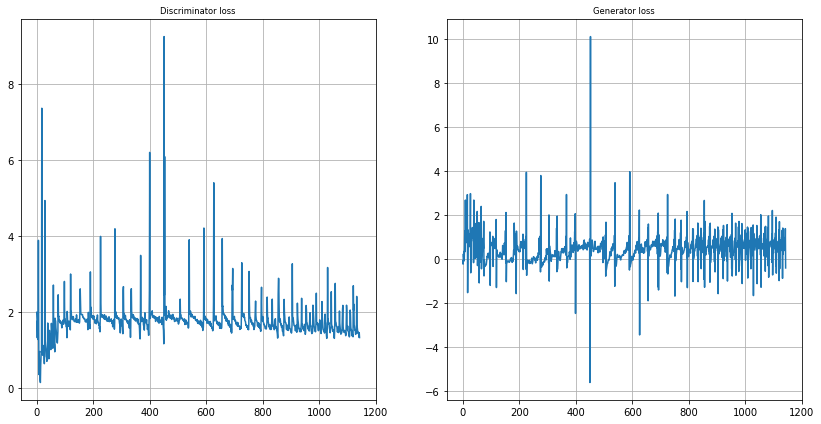

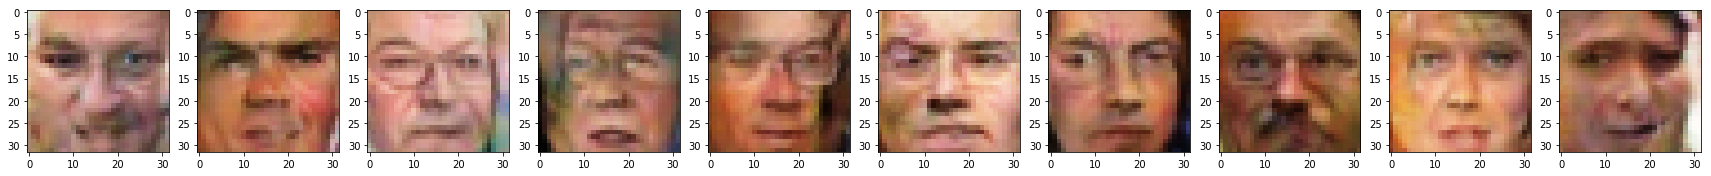












 87%|████████▋ | 26/30 [04:10<00:38,  9.73s/it]










 90%|█████████ | 27/30 [04:20<00:28,  9.62s/it]










 93%|█████████▎| 28/30 [04:29<00:18,  9.48s/it]










 97%|█████████▋| 29/30 [04:38<00:09,  9.39s/it]










100%|██████████| 30/30 [04:47<00:00,  9.59s/it]


In [40]:
train(grad_penalty=0, spectral=False, batchnorm=False)

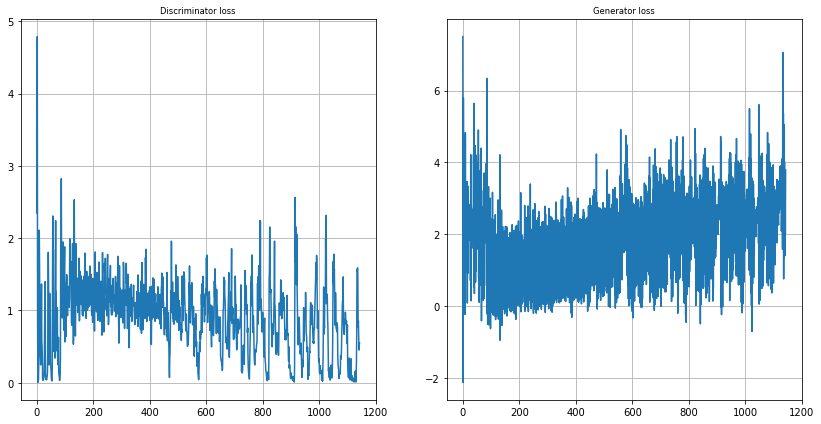

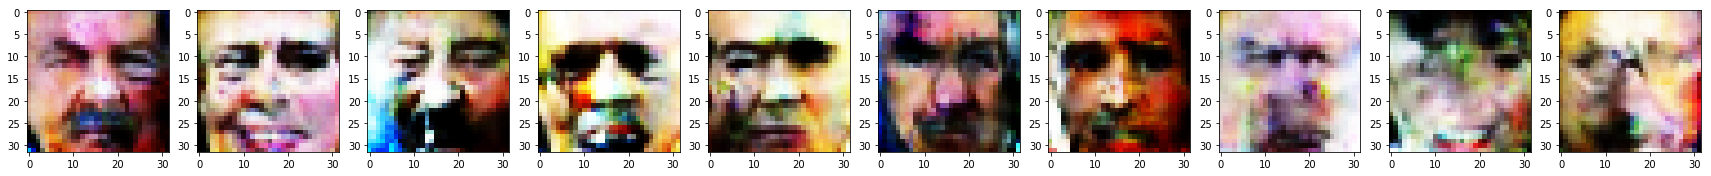












 87%|████████▋ | 26/30 [04:28<00:41, 10.39s/it]










 90%|█████████ | 27/30 [04:38<00:30, 10.20s/it]










 93%|█████████▎| 28/30 [04:48<00:20, 10.10s/it]










 97%|█████████▋| 29/30 [04:58<00:10, 10.01s/it]










100%|██████████| 30/30 [05:07<00:00, 10.26s/it]


In [41]:
train(grad_penalty=0, spectral=False, batchnorm=True)

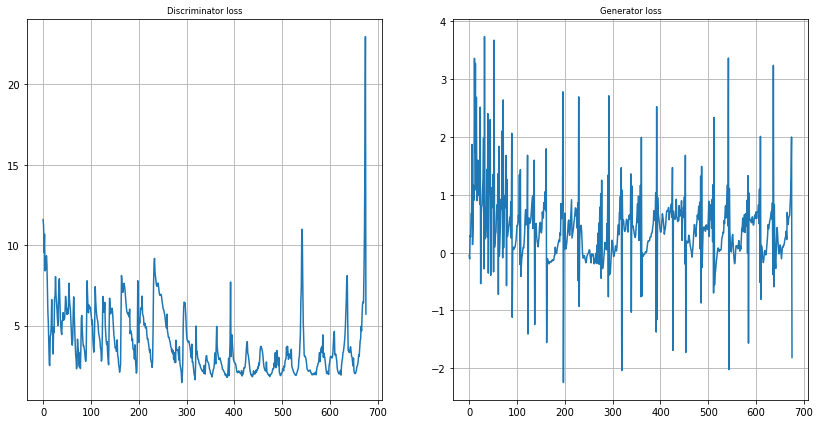

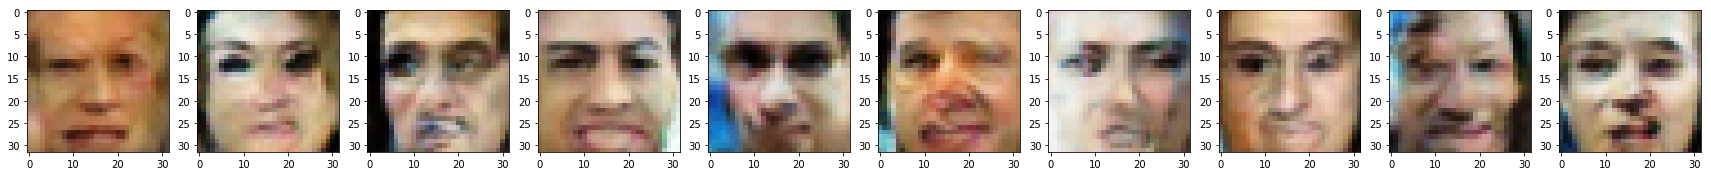














 87%|████████▋ | 26/30 [04:36<00:45, 11.27s/it]












 90%|█████████ | 27/30 [04:47<00:33, 11.19s/it]












 93%|█████████▎| 28/30 [04:58<00:22, 11.14s/it]












 97%|█████████▋| 29/30 [05:08<00:10, 10.94s/it]












100%|██████████| 30/30 [05:18<00:00, 10.63s/it]


In [48]:
train(grad_penalty=10, spectral=False, batchnorm=False)

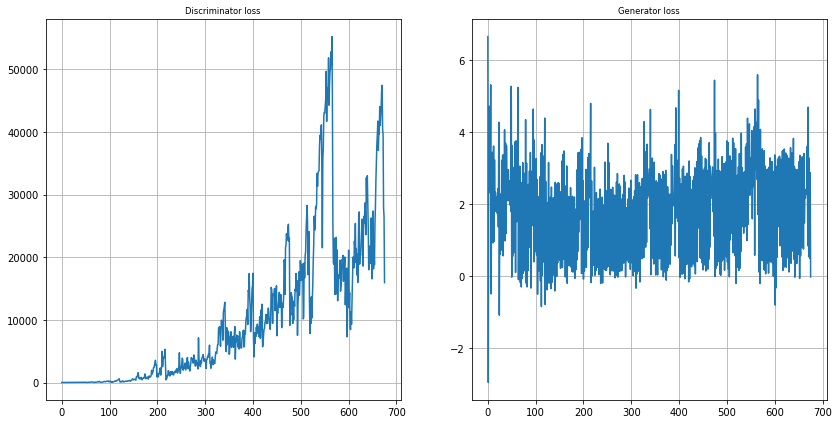

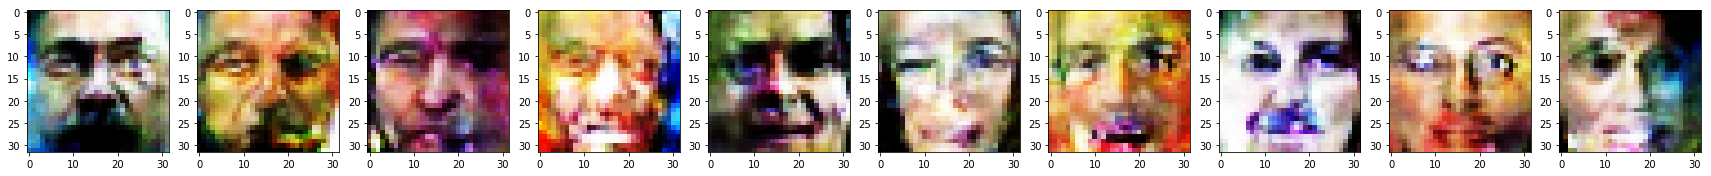














 87%|████████▋ | 26/30 [05:19<00:49, 12.48s/it]












 90%|█████████ | 27/30 [05:32<00:37, 12.43s/it]












 93%|█████████▎| 28/30 [05:44<00:24, 12.49s/it]












 97%|█████████▋| 29/30 [05:57<00:12, 12.49s/it]












100%|██████████| 30/30 [06:09<00:00, 12.32s/it]


In [49]:
train(grad_penalty=10, spectral=False, batchnorm=True)

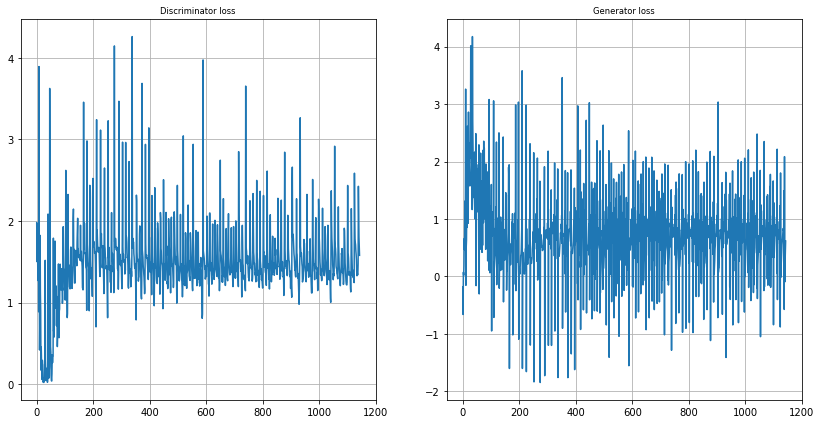

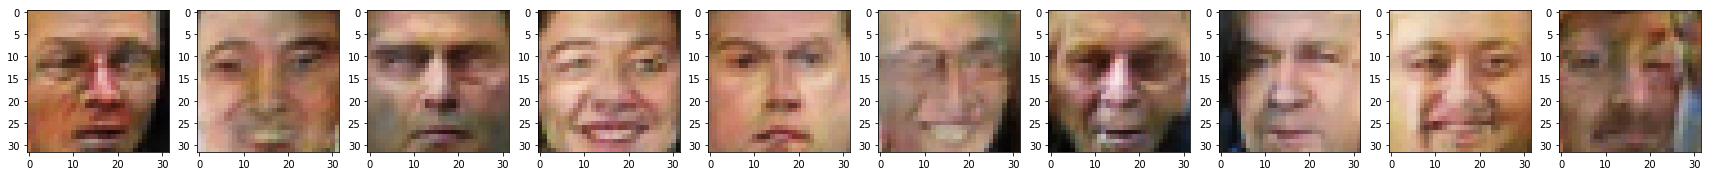













 87%|████████▋ | 26/30 [03:54<00:37,  9.39s/it]











 90%|█████████ | 27/30 [04:03<00:27,  9.24s/it]











 93%|█████████▎| 28/30 [04:12<00:18,  9.19s/it]











 97%|█████████▋| 29/30 [04:21<00:09,  9.07s/it]











100%|██████████| 30/30 [04:30<00:00,  9.02s/it]


In [43]:
train(grad_penalty=0, spectral=True, batchnorm=False)

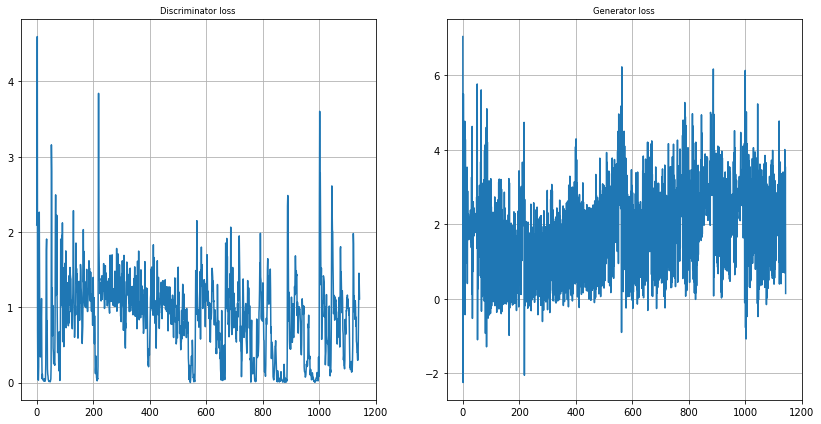

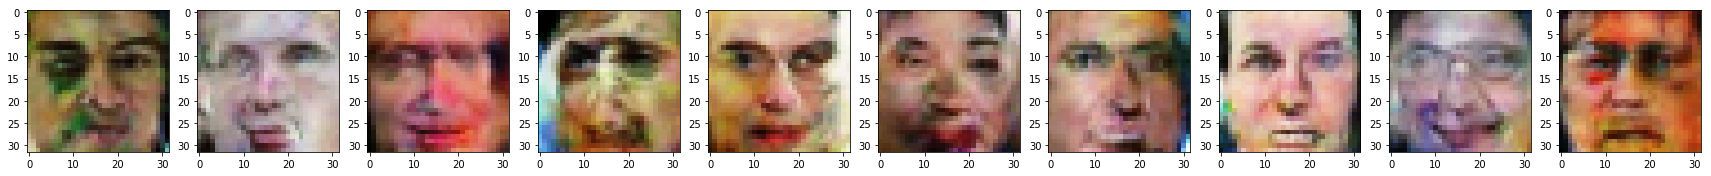













 87%|████████▋ | 26/30 [04:23<00:41, 10.32s/it]











 90%|█████████ | 27/30 [04:33<00:30, 10.11s/it]











 93%|█████████▎| 28/30 [04:42<00:19,  9.96s/it]











 97%|█████████▋| 29/30 [04:52<00:09,  9.89s/it]











100%|██████████| 30/30 [05:02<00:00, 10.08s/it]


In [44]:
train(grad_penalty=0, spectral=True, batchnorm=True)